### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import os
import torch
import seaborn as sns

/Users/catarina/Desktop/DataScience/DataScienceProjects/FruitsDetection/fruits-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read dataset labels

In [2]:
# Set the folder path
folder_path = 'fruits-detection/train/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      3      0.015625      0.525781      0.030859      0.079687  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
1      3      0.026562      0.782031      0.053125      0.104688  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
2      3      0.029687      0.953906      0.059375      0.089063  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
3      3      0.035937      0.603125      0.071094      0.075781  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
4      3      0.021875      0.679688      0.037891      0.072656  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange


### Check images

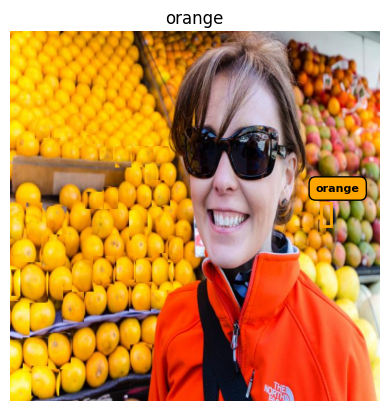

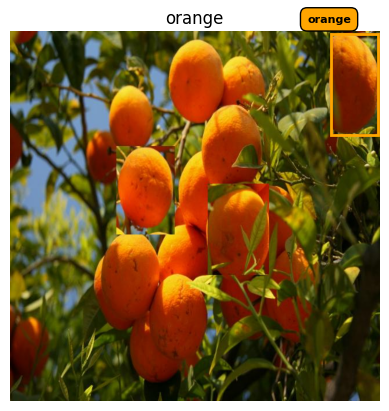

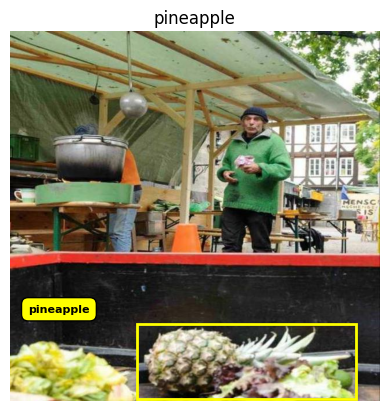

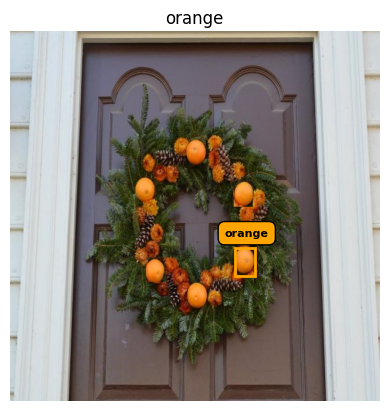

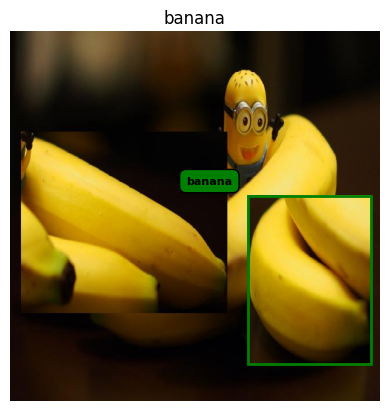

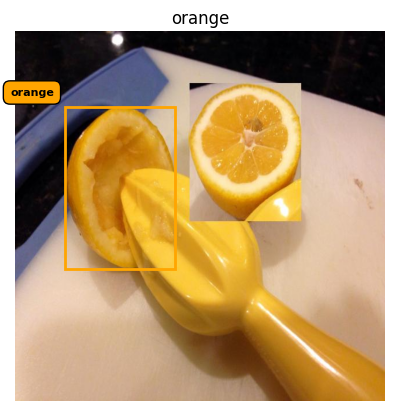

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_images_with_bounding_boxes(dataframe, folder_path, max_rows=100):
    # Group the DataFrame by filename and iterate through each group
    for _, group in dataframe[:max_rows].groupby('filename'):
        # Load the image
        image_path = os.path.join(folder_path, group.iloc[0]['filename'])  # Use the filename of the first row in the group
        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error loading image {group.iloc[0]['filename']}: {e}")
            continue

        # Create a subplot
        fig, ax = plt.subplots()
        ax.imshow(image)
        ax.axis('off')

        # Define colors for different labels
        label_colors = {'apple': 'red', 'banana': 'green', 'grape': 'white', 'orange': 'orange', 'pineapple': 'yellow', 'watermelon': 'pink'}

        # Iterate through each unique label in the group and plot the bounding box
        for label, color in label_colors.items():
            label_group = group[group['class_name'] == label]
            if not label_group.empty:
                row = label_group.iloc[-1]  # Take the last row for the label
                width, height = image.size
                x_center, y_center, bbox_width, bbox_height = row[['coordinate_1', 'coordinate_2', 'coordinate_3', 'coordinate_4']]
                x1 = (x_center - bbox_width / 2) * width
                y1 = (y_center - bbox_height / 2) * height
                rect = patches.Rectangle((x1, y1), bbox_width * width, bbox_height * height, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                # Calculate the position of the label outside the bounding box
                text_x = x1 - bbox_width * width / 2  # Adjusted x position
                text_y = y1 - 20  # Adjusted y position
                bbox_props = dict(boxstyle="round,pad=0.6", fc=color, ec="black", lw=1)  # Background properties
                ax.text(text_x, text_y, label, fontsize=8, color='black', weight='bold', bbox=bbox_props)

        # Add title
        unique_labels = set(group['class_name'])
        ax.set_title(', '.join(unique_labels))  # Use the unique labels in the group as the title
        plt.show()

folder_path = 'fruits-detection/train/images/'
plot_images_with_bounding_boxes(final_df, folder_path)

### Find images that have more than one fruit type

In [4]:
# Group by 'filename' and check for differing 'class_name'
rows_with_different_classes = final_df[final_df.duplicated(subset='filename', keep=False)]
rows_with_different_classes = rows_with_different_classes.groupby('filename').filter(lambda x: len(set(x['class_name'])) > 1)

# Display the result
rows_with_different_classes

label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename  class_name
146        1      0.686719      0.641406      0.157812      0.192969  d9b22866a65a88bd_jpg.rf.18a428a32731bafa544e2770eecc701f.jpg      banana
147        4      0.708594      0.420312      0.187500      0.565234  d9b22866a65a88bd_jpg.rf.18a428a32731bafa544e2770eecc701f.jpg   pineapple
203        0      0.792188      0.076563      0.180859      0.153125  212f29ce83ba711b_jpg.rf.f5a344896620f8635506558fad34971f.jpg       apple
204        0      0.896875      0.184375      0.205469      0.164062  212f29ce83ba711b_jpg.rf.f5a344896620f8635506558fad34971f.jpg       apple
205        5      0.509375      0.569531      0.778516      0.761328  212f29ce83ba711b_jpg.rf.f5a344896620f8635506558fad34971f.jpg  watermelon
...      ...           ...           ...           ...           ...                                                           ...         ...
32013      2      0.710938      0.698438      0.174219      0.243750  076510c625071bb2_jpg.rf.1380f555fd1190d2cd0f1ba2c6532ce7.jpg       grape
32014      2      0.720313      0.307031      0.054688      0.060937  076510c625071bb2_jpg.rf.1380f555fd1190d2cd0f1ba2c6532ce7.jpg       grape
32015      2      0.760938      0.364844      0.076563      0.099219  076510c625071bb2_jpg.rf.1380f555fd1190d2cd0f1ba2c6532ce7.jpg       grape
32016      5      0.807813      0.473438      0.143750      0.369141  076510c625071bb2_jpg.rf.1380f555fd1190d2cd0f1ba2c6532ce7.jpg  watermelon
32017      5      0.548438      0.514062      0.644141      0.893359  076510c625071bb2_jpg.rf.1380f555fd1190d2cd0f1ba2c6532ce7.jpg  watermelon

[1610 rows x 7 columns]

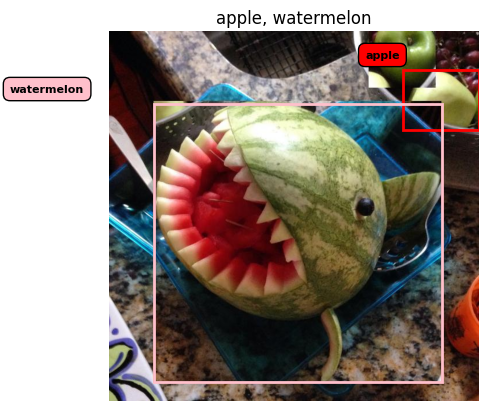

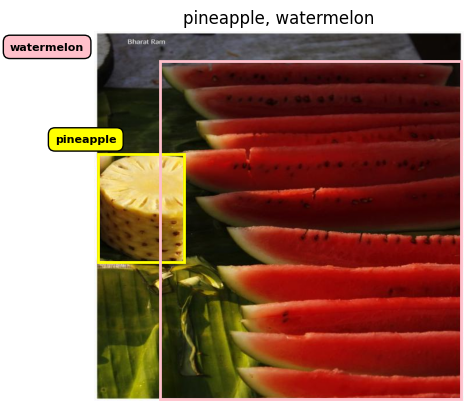

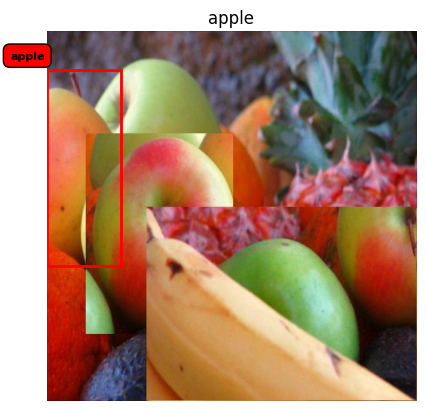

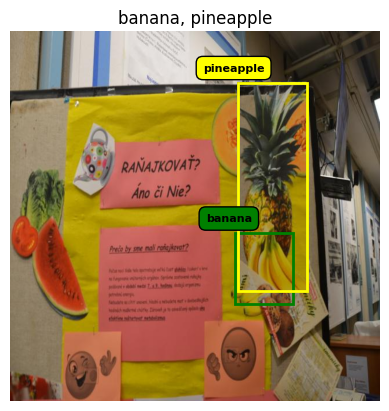

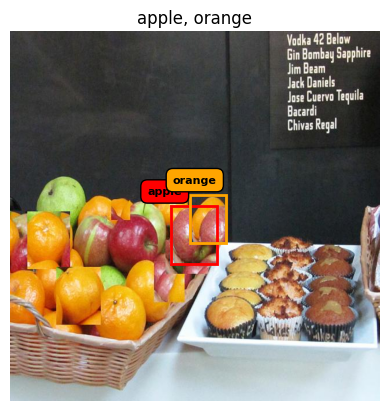

In [5]:
plot_images_with_bounding_boxes(rows_with_different_classes, folder_path, max_rows=30)

Since we are going to identify what's in the image (classification task) we can remove all the coordinates followed by the duplicate rows

In [6]:
final_df = final_df.loc[:, ~final_df.columns.str.startswith('coordinate_')]
final_df.drop_duplicates(inplace=True)
print(final_df.head(10))

     label                                                      filename class_name
0        3  000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg     orange
83       4  16d6f1e3fd4443ac_jpg.rf.efc9727f1c46b50814e57b4531f345aa.jpg  pineapple
84       3  17cc9895a4c6b32b_jpg.rf.1c424669691a15f97b943fdc23d9cfaa.jpg     orange
90       1  87eea574340d5d48_jpg.rf.bed151caef6965fe2806b2309278783e.jpg     banana
94       3  093d9c02650b69bc_jpg.rf.1b57af4d3140051819d5c53e73b3d9b4.jpg     orange
99       3  b8208415b699481c_jpg.rf.6387b8a7eaf115cc25ceb515d6a974b8.jpg     orange
101      2  4bac3cc0022db7d3_jpg.rf.9fc195a6198eca41b7d5403e72f0c227.jpg      grape
102      0  a9066c613e840878_jpg.rf.1cd83f5a7902932675e3278c51bf2c03.jpg      apple
103      2  41a81ccea2949e58_jpg.rf.cc8ff4dfcd21d95f09a7c9b96cd78b06.jpg      grape
104      3  53b4f49b09747d35_jpg.rf.839aa688922bf79e7511c45da2fea2f4.jpg     orange


In [7]:
len(final_df)

7387

In [8]:
len(final_df['filename'].unique())

7108

#### Read images

In [9]:
image_names = final_df['filename'].tolist()
image_names[:5]

['000d1976fc8ebfe7_jpg.rf.101a196ad8bb2049400327fc662a677e.jpg',
 '16d6f1e3fd4443ac_jpg.rf.efc9727f1c46b50814e57b4531f345aa.jpg',
 '17cc9895a4c6b32b_jpg.rf.1c424669691a15f97b943fdc23d9cfaa.jpg',
 '87eea574340d5d48_jpg.rf.bed151caef6965fe2806b2309278783e.jpg',
 '093d9c02650b69bc_jpg.rf.1b57af4d3140051819d5c53e73b3d9b4.jpg']

In [10]:
# Extract each image file by iterating through this list of files
images = []
root = 'fruits-detection/train/images/'

# Iterate through each image file name
for img_name in tqdm(image_names):
    # Construct the complete path of each image file
    image_path = os.path.join(root, img_name)
    
    # Open each image file using PIL (Python Imaging Library) and convert it into a numpy array
    image = np.asarray(Image.open(image_path), dtype='uint8')
    
    # Append the numpy array representation of the image to the 'images' list
    images.append(image)

# Convert the list of images into a numpy array
images = np.array(images)

# Find unique images in the array, removing duplicates
unique_images = np.unique(images, axis=0)

100%|██████████| 7387/7387 [00:25<00:00, 289.35it/s]


In [12]:
np.array(image).shape

(640, 640, 3)

In [13]:
images.shape

(7387, 640, 640, 3)

In [14]:
images

array([[[[255, 177,   0],
         [255, 176,   0],
         [255, 174,   0],
         ...,
         [123, 145, 143],
         [123, 145, 143],
         [123, 145, 143]],

        [[255, 170,   0],
         [255, 170,   0],
         [255, 169,   0],
         ...,
         [119, 141, 139],
         [123, 145, 143],
         [125, 147, 145]],

        [[255, 162,   0],
         [254, 161,   0],
         [252, 160,   0],
         ...,
         [112, 132, 131],
         [117, 137, 136],
         [121, 141, 140]],

        ...,

        [[253, 212,   0],
         [253, 212,   0],
         [253, 212,   0],
         ...,
         [255, 245, 183],
         [255, 249, 187],
         [254, 248, 186]],

        [[252, 211,   0],
         [252, 211,   0],
         [252, 211,   0],
         ...,
         [255, 245, 183],
         [255, 248, 186],
         [254, 248, 186]],

        [[252, 211,   0],
         [251, 210,   0],
         [251, 210,   0],
         ...,
         [254, 244, 182],
        

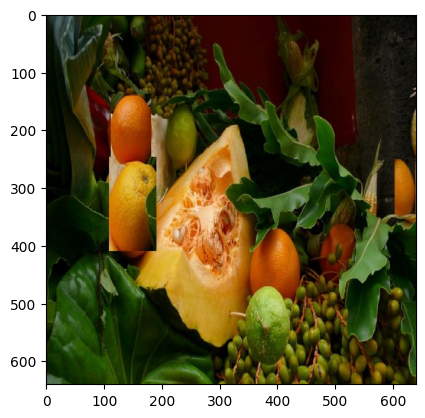

In [15]:
plt.imshow(image)

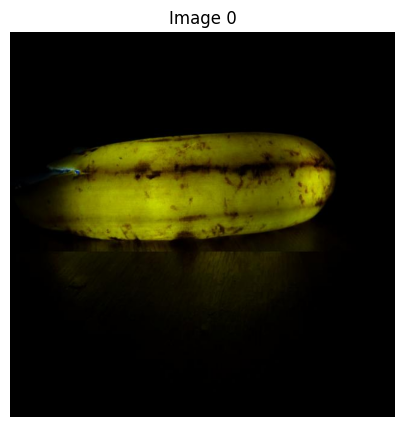

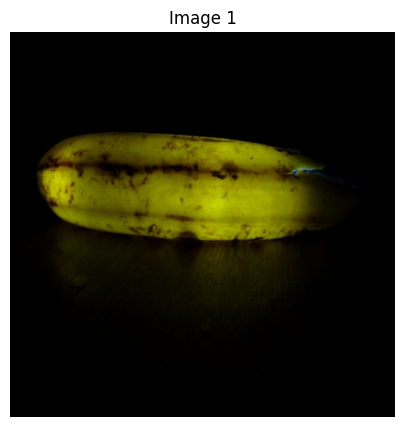

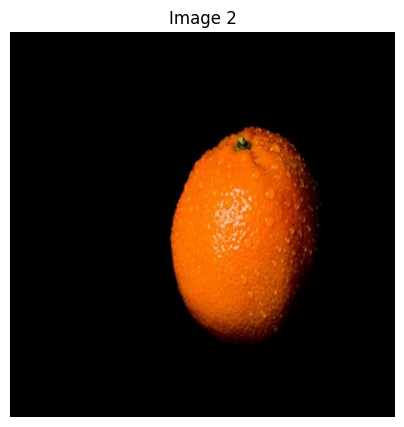

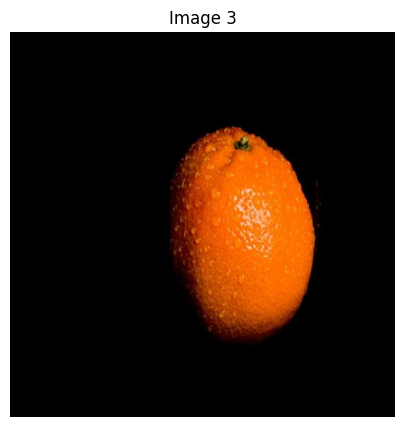

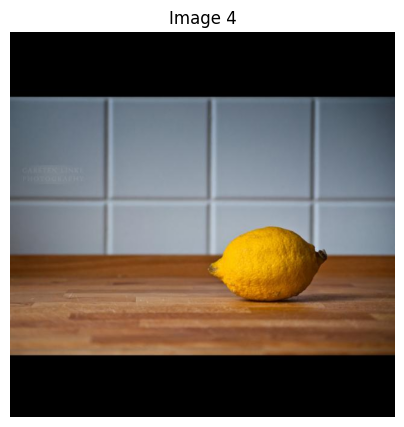

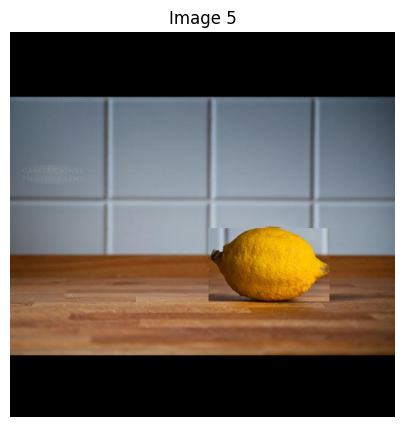

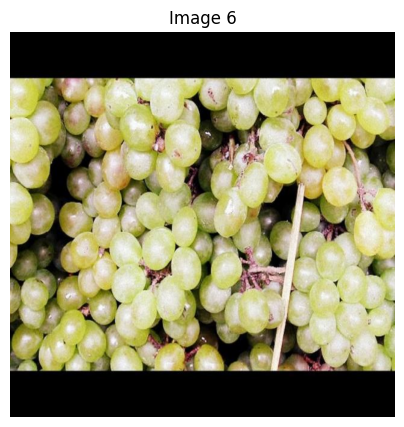

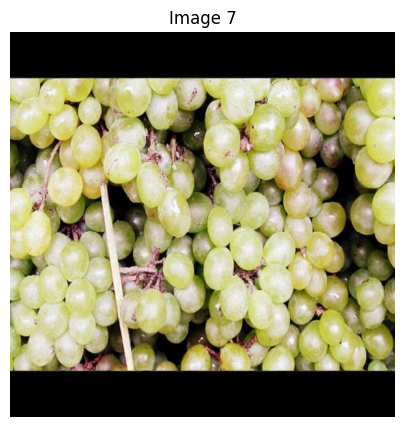

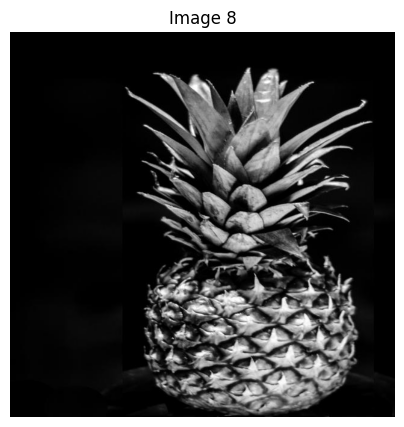

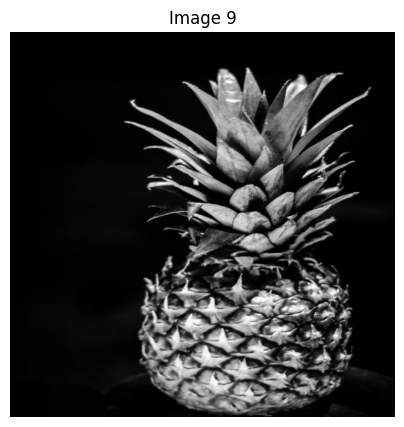

In [18]:
import matplotlib.pyplot as plt

# Plot each image separately
for i in range(10):  # Plotting images from index 5 to 15
    plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
    plt.imshow(unique_images[i])
    plt.axis('off')
    plt.title(f'Image {i}')  # Set title with image index
    plt.show()

### Labels statistics

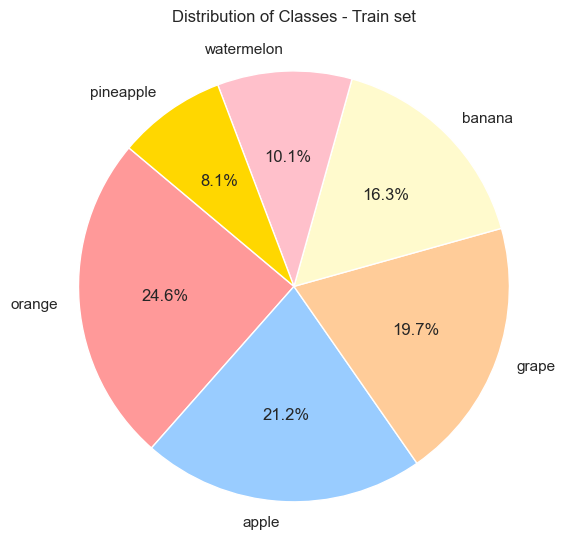

In [19]:
# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts = final_df['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Train set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

In [20]:
class_counts

class_name
orange        1818
apple         1564
grape         1453
banana        1205
watermelon     746
pineapple      601
Name: count, dtype: int64

#### Checking the proportion for the test and validation sets

In [21]:
# Set the folder path
folder_path = 'fruits-detection/test/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df_test = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df_test.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      2      0.266406      0.409375      0.267188      0.221094  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
1      2      0.406250      0.521094      0.050000      0.055469  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
2      2      0.596094      0.697656      0.314844      0.435156  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
3      2      0.633594      0.295312      0.335156      0.335938  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape
4      2      0.689063      0.542969      0.064062      0.085156  49a87bf5fcf6153a_jpg.rf.b5e538be37e2c0a593289022673b9685.jpg      grape


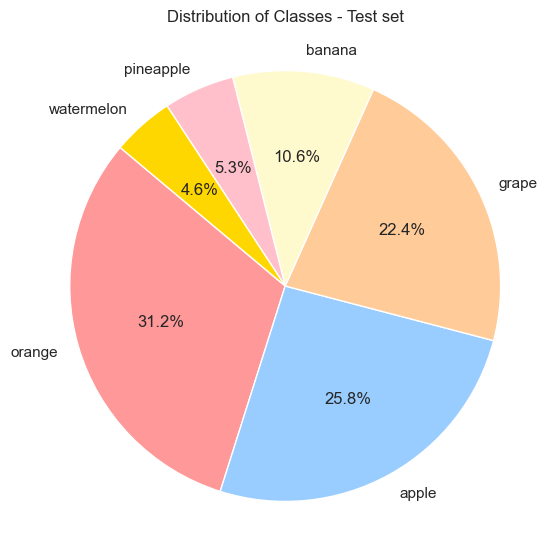

In [22]:
# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts_test = final_df_test['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts_test, labels=class_counts_test.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Test set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

In [23]:
# Set the folder path
folder_path = 'fruits-detection/valid/labels/'

# Class names
class_names = {0: 'apple', 1: 'banana', 2: 'grape', 3: 'orange', 4: 'pineapple', 5: 'watermelon'}

# Create an empty list to store DataFrames
dfs = []

# Iterate through the files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        file_path = os.path.join(folder_path, file)
        # Read the text file into a DataFrame
        df = pd.read_csv(file_path, delimiter=" ", names=["label", "coordinate_1", "coordinate_2", "coordinate_3", "coordinate_4"])  # Adjust column names as needed
        # Add file name without extension
        df["filename"] = os.path.splitext(file)[0] + '.jpg'
        # Map numeric labels to class names
        df["class_name"] = df["label"].map(class_names)
        dfs.append(df)

# Concatenate all DataFrames into one
final_df_val = pd.concat(dfs, ignore_index=True)

# Display settings
df.style.set_properties(**{'text-align': 'center'})
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

# Display the concatenated DataFrame
print(final_df_val.head())

   label  coordinate_1  coordinate_2  coordinate_3  coordinate_4                                                      filename class_name
0      3      0.753906      0.795312      0.232031      0.257031  6e493cf6c5db3db0_jpg.rf.d5d316ec2e29f2e331d7293bcb2ad2cb.jpg     orange
1      2      0.029687      0.710938      0.057813      0.099219  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
2      2      0.021094      0.724219      0.014063      0.029687  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
3      2      0.028906      0.678906      0.009375      0.020313  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape
4      2      0.126562      0.764844      0.185938      0.331250  b22497d1ac4ece41_jpg.rf.28e2703d116a363e786ddde36272439c.jpg      grape


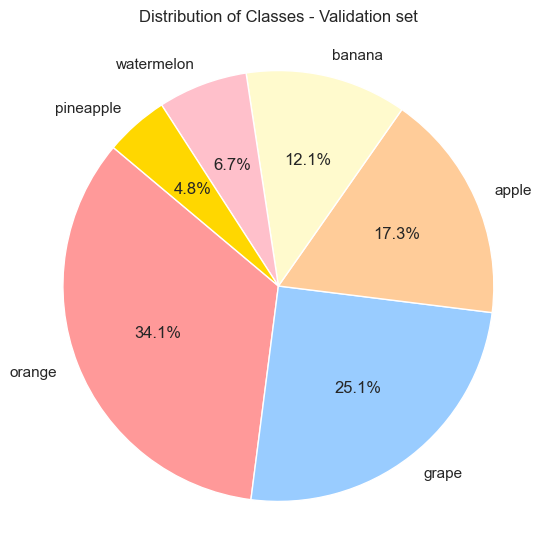

In [24]:
# Set seaborn style
sns.set(style="whitegrid")

# Count the occurrences of each class
class_counts_val = final_df_val['class_name'].value_counts()

# Define custom color palette
custom_palette = ['#FF9999', '#99CCFF', '#FFCC99', '#FFFACD', '#FFC0CB', '#FFD700']

# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts_val, labels=class_counts_val.index, autopct='%1.1f%%', startangle=140, colors=custom_palette)
plt.title('Distribution of Classes - Validation set', pad=20)  # Adjusting title spacing
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.gca().set_facecolor('white')  # Set white background

# Adjust spacing between title and plot
plt.subplots_adjust(top=0.9)

plt.show()

We can see a very umbalanced dataset - we'll need to address this when loading the data into the loader